In [39]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import seaborn as sns

# sns.set(style="ticks", context="talk")
# plt.style.use("dark_background")


In [40]:
def _delta(current, reference):
    return current - reference

def _delta_percent(current, reference):
    return (current / reference - 1) * 100


class DataSystem:
    def __init__(self, countries=[]):
        self.countries= countries
        self.data = None
    
    def update(self):
        URL = "https://pomber.github.io/covid19/timeseries.json"
        _dat = requests.get(URL).json()
        
        self.data = {country: CountryData(country, _dat) for country in self.countries}


    def daily_stats(self, country, ref_country, metric="deaths", rolling_days=3, y_0=10, plots=True):
        """ gets daily metrics on rolling days, y_0 refers to metric at the day used as starting date. e.g. default: deaths metrics starting from 10 deaths.
        """
        country = self.data[country]
        ref_country = self.data[ref_country]
        df = country.get_df()
        df_ref = ref_country.get_df()

        new_metric = "{}day_{}".format(rolling_days, metric)
        df[new_metric] = df.loc[df[metric] > y_0][metric] - df.loc[df[metric] > y_0][metric].shift(rolling_days, fill_value=0)

        df2 = df.loc[df[metric] > y_0] - df.loc[df[metric] > y_0].shift(rolling_days, fill_value=0)

        df_ref[new_metric] = df_ref.loc[df_ref[metric] > y_0][metric] - df_ref.loc[df_ref[metric] > y_0][metric].shift(rolling_days, fill_value=0)

        df_ref2  = df_ref.loc[df_ref[metric] > y_0] - df_ref.loc[df_ref[metric] > y_0].shift(rolling_days, fill_value=0)




        n_days = df_ref2.shape[0]
        idx = pd.date_range(df2.index[0] , df2.index[0] + pd.Timedelta("{} days".format(n_days)))
        df2 = df2.reindex(idx, fill_value=0)
        dateformat = mdates.DateFormatter('%d %b')

        if plots:
            fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), gridspec_kw={"height_ratios": [3,2]})
            axes[0].bar(df2.index, df2[metric], color="darkblue")
            axes[0].set_title("{} {}-day {}".format(country.name, rolling_days, metric.title()))
            axes[0].set_ylabel(str(metric).title())
            axes[0].xaxis.set_major_formatter(dateformat)

            axes[1].bar(df_ref2.index, df_ref2[metric], color="mediumseagreen")
            axes[1].set_title("{}  {}-day {}".format(ref_country.name, rolling_days, metric.title()))
            axes[1].set_ylabel(str(metric).title())
            axes[1].xaxis.set_major_formatter(dateformat)

            fig.tight_layout()
            plt.show()
            file_path = "{}.png".format(new_metric)
            fig.savefig(file_path)

        new_data = df[new_metric][-1]
        new_data_delta = _delta_percent(df[new_metric][-1], df[new_metric][-2])
        daily_deaths = df["daily_deaths"][-1]
        daily_deaths_delta = _delta_percent(df["daily_deaths"][-1], df["daily_deaths"][-2])
        return {"fig_path": file_path , "new_data": new_data, "new_data_delta": new_data_delta, "daily_deaths": daily_deaths, "daily_deaths_delta": daily_deaths_delta}


class CountryData:
    def __init__(self, name, data_json):
        self.name = name
        self.data = data_json[name]
        self.df = self.setup_data()

    def setup_data(self):
        country_df = pd.DataFrame(self.data)
        country_df["date"] = country_df["date"].apply(pd.to_datetime)
        country_df.index = country_df["date"]
        country_df["daily_deaths"] = country_df["deaths"] - country_df["deaths"].shift(1)
        return country_df

    def get_df(self):
        return self.df



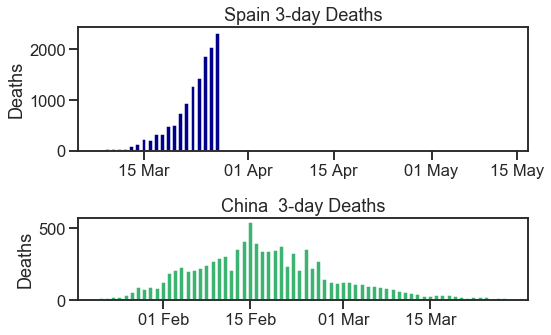

In [41]:
system = DataSystem(countries=["Spain", "China"])
system.update()
query_data = system.daily_stats("Spain", "China", metric="deaths", rolling_days=3, y_0=10, plots=True)

In [45]:

spain = data["Spain"]
china = data["China"]


In [99]:
def setup_data(country_data):
    country_df = pd.DataFrame(country_data)
    country_df["date"] = country_df["date"].apply(pd.to_datetime)
    country_df.index = country_df["date"]
    country_df["new_deaths"] = country_df["deaths"] - spain_df2["deaths"].shift(1)

    return country_df

spain_df = setup_data(spain)
china_df = setup_data(china)

In [ ]:
def daily_stats(country, ref_country, metric="deaths", rolling_days=1, y_0=10, plots=True):
    """ gets daily metrics on rolling days, y_0 refers to metric at the day used as starting date. e.g. default: deaths metrics starting from 10 deaths.
    """
    df = country.get_df()
    df_ref = country.get_df()

    new_metric = "{}day_{}".format(rolling_days, metric)
    df[new_metric] = df.loc[df[metric] > y_0][metric] - df.loc[df[metric] > y_0][metric].shift(rolling_days, fill_value=0)

    df_ref[new_metric] = df_ref.loc[df_ref[metric] > y_0][metric] - df_ref.loc[df[metric] > y_0][metric].shift(rolling_days, fill_value=0)

    n_days = df_ref.shape[0]
    idx = pd.date_range(df.index[0] , df.index[0] + pd.Timedelta("{} days".format(n_days)))
    df2 = df.reindex(idx, fill_value=0)
    dateformat = mdates.DateFormatter('%d %b')

    if plots:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), gridspec_kw={"height_ratios": [3,2]})
        axes[0].bar(df2.index, df2["new_metric"])
        axes[0].set_title(country.name)
        axes[0].xaxis.set_major_formatter(dateformat)

        axes[1].bar(df_ref.index, df_ref["new_metric"])
        axes[1].set_title(ref_country.name)
        axes[1].xaxis.set_major_formatter(dateformat)

        fig.tight_layout()
        fig.savefig("{}.png".format(new_metric))

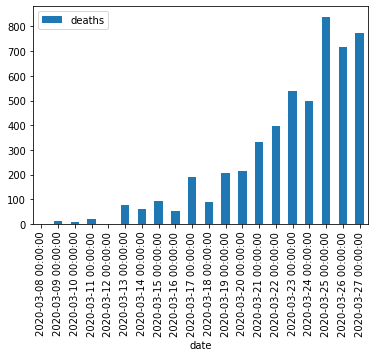

In [52]:
spain_daily = spain_df.loc[spain_df["deaths"] > 10] - spain_df.loc[spain_df["deaths"] > 10].shift(1)

spain_daily.plot(y="deaths", kind="bar")


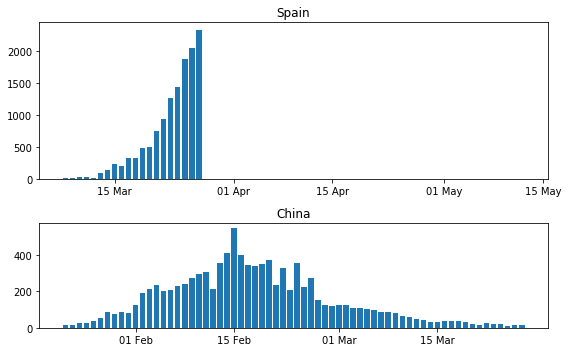

In [153]:
china_daily = china_df.loc[china_df["deaths"] >= 10] - china_df.loc[china_df["deaths"] > 10].shift(3, fill_value=0)
spain_daily = spain_df.loc[spain_df["deaths"] >= 10] - spain_df.loc[spain_df["deaths"] > 10].shift(3, fill_value=0)


# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 3), gridspec_kw={'width_ratios': [2, 3]})
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), gridspec_kw={"height_ratios": [3,2]})

myFmt = mdates.DateFormatter('%d %b')



axes[1].bar(china_daily.index, china_daily["deaths"])
axes[1].set_title("China")
axes[1].xaxis.set_major_formatter(myFmt)

n_days = china_daily.shape[0]
idx = pd.date_range(spain_daily.index[0] , spain_daily.index[0] + pd.Timedelta("{} days".format(n_days)))
spain2 = spain_daily.reindex(idx, fill_value=0)
axes[0].bar(spain2.index, spain2["deaths"])
axes[0].set_title("Spain")
axes[0].xaxis.set_major_formatter(myFmt)


fig.tight_layout()

In [135]:
china_daily.shape

(66, 4)

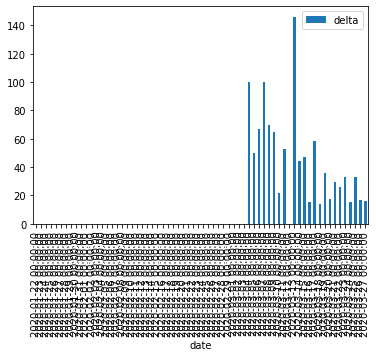

In [96]:
def _delta_percent(current, reference):
    return (current / reference - 1) * 100


spain_daily["delta"] = (spain_daily["deaths"] / spain_daily["deaths"].shift(1)  - 1) * 100

spain_daily.plot(kind="bar", y="delta") 

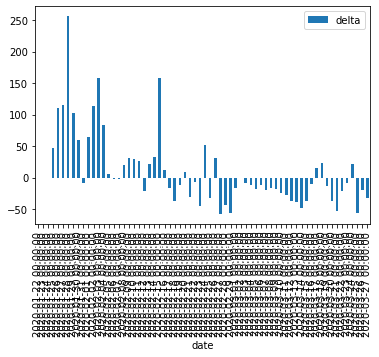

In [149]:
china_daily["delta"] = (china_daily["deaths"] / china_daily["deaths"].shift(3)  - 1) * 100

china_daily.plot(kind="bar", y="delta")

In [120]:
print(_delta_percent(spain_df[-1:].deaths.values,spain_df[-2:-1].deaths.values))

[17.70904926]


In [128]:
spain_df2 = spain_df.copy()

spain_df2["delta_death"] = spain_df2["deaths"] - spain_df2["deaths"].shift(1)


In [129]:
spain_df2.describe()

,confirmed,deaths,recovered,delta_death
count,66.000000,66.000000,66.000000,65.000000
mean,6143.530303,388.090909,604.560606,79.046154
std,14266.547760,1036.132271,1666.471520,192.483070
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,2.000000,0.000000
75%,2131.500000,49.250000,145.250000,11.000000
max,65719.000000,5138.000000,9357.000000,839.000000


In [132]:
spain_df2.tail()

,date,confirmed,deaths,recovered,delta_death
date,,,,,
2020-03-23,2020-03-23,35136,2311,2575,539.0
2020-03-24,2020-03-24,39885,2808,3794,497.0
2020-03-25,2020-03-25,49515,3647,5367,839.0
2020-03-26,2020-03-26,57786,4365,7015,718.0
2020-03-27,2020-03-27,65719,5138,9357,773.0


In [152]:
spain_df2["deaths"][-1]

5138

In [50]:
from telegram import Bot

ImportError: cannot import name 'Bot' from 'telegram' (/Users/marc/Documents/code/_projects/raspi_projects/covid_bot/telegram.py)

In [49]:
bot = Bot('990032938:AAHXzZgkXbL6G25jMGeZIWofyfddO88IOaw')

NameError: name 'Bot' is not defined